## Criteo Uplift Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import matplotlib.style as style
import seaborn as sns

In [2]:
df = pd.read_csv('criteo-uplift-v2.1.csv')
# 特徴量を正規化
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


## Cost Aware Assignment Problem

In [3]:
# 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split

X = df.drop(['treatment','exposure','visit','conversion'], axis=1)
# Xの特徴量を正規化
X = (X - X.mean()) / X.std()
T = df['treatment']
y_r = df['conversion']
y_c =df['visit']

X_train, X_test, T_train, T_test, y_r_train, y_r_test, y_c_train, y_c_test = train_test_split(X, T, y_r, y_c, train_size=0.7, random_state=42, stratify=T)
# X_train, X_val, T_train, T_val, y_r_train, y_r_val, y_c_train, y_c_val = train_test_split(X_train_val, T_train_val, y_r_train_val, y_c_train_val, train_size=0.7, random_state=42, stratify=T_train_val)

T_test = T_test.reset_index(drop=True)
y_r_test = y_r_test.reset_index(drop=True)
y_c_test = y_c_test.reset_index(drop=True)

### 提案手法

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler
from tqdm import tqdm

# データをテンソルに変換
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_r_train_tensor = torch.tensor(y_r_train.values, dtype=torch.float32)
y_c_train_tensor = torch.tensor(y_c_train.values, dtype=torch.float32)
T_train_tensor = torch.tensor(T_train.values, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
# y_r_val_tensor = torch.tensor(y_r_val.values, dtype=torch.float32)
# y_c_val_tensor = torch.tensor(y_c_val.values, dtype=torch.float32)
# T_val_tensor = torch.tensor(T_val.values, dtype=torch.float32)

# データをテンソルに変換してDatasetを作成
dataset_1 = TensorDataset(X_train_tensor[T_train_tensor == 1], y_r_train_tensor[T_train_tensor == 1], y_c_train_tensor[T_train_tensor == 1])
dataset_0 = TensorDataset(X_train_tensor[T_train_tensor == 0], y_r_train_tensor[T_train_tensor == 0], y_c_train_tensor[T_train_tensor == 0])
# dataset_1_val = TensorDataset(X_val_tensor[T_val_tensor == 1], y_r_val_tensor[T_val_tensor == 1], y_c_val_tensor[T_val_tensor == 1])
# dataset_0_val = TensorDataset(X_val_tensor[T_val_tensor == 0], y_r_val_tensor[T_val_tensor == 0], y_c_val_tensor[T_val_tensor == 0])

# DataLoaderの定義
loader_1 = DataLoader(dataset_1, batch_size=170, shuffle=True)
loader_0 = DataLoader(dataset_0, batch_size=30, shuffle=True)
# loader_1_val = DataLoader(dataset_1_val, batch_size=170, shuffle=True)
# loader_0_val = DataLoader(dataset_0_val, batch_size=30, shuffle=True)

# 非線形モデルの定義
class NonLinearModel(nn.Module):
    def __init__(self, input_dim):
        super(NonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 36)
        # self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(36, 18)
        # self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(18, 6)
        # self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(6, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout1(x)  # Dropoutを適用
        x = torch.relu(self.fc2(x))
        # x = self.dropout2(x) 
        x = torch.relu(self.fc3(x))
        # x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))
        return x


# model = LogisticRegressionModel(X_train_tensor.shape[1])
model = NonLinearModel(X_train_tensor.shape[1])

# 損失関数の定義
def custom_loss(y_r, y_c, q, group_size):
    # qの値を1e-6と1-1e-6の間にクリップする
    q = torch.clamp(q, 1e-8, 1 - 1e-8)
    logit_q = torch.log(q / (1 - q))

    # 損失計算
    loss = -torch.sum(y_r * logit_q + y_c * torch.log(1 - q)) / group_size
    return loss

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# 1. LambdaLR
# lambda_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

loss_history, loss_history_val = [], []  # 損失を記録するリストを初期化

# 学習ループ
for epoch in range(20):
    model.train()
    total_loss = 0  # このエポックの総損失を追跡
    count_batches = 0  # 処理したバッチの数

    for (x_1, y_r_1, y_c_1), (x_0, y_r_0, y_c_0) in tqdm(zip(loader_1, loader_0)):
        optimizer.zero_grad()
        
        q_1 = model(x_1)
        q_0 = model(x_0)
        
        loss_1 = custom_loss(y_r_1, y_c_1, q_1, x_1.size(0))
        loss_0 = custom_loss(y_r_0, y_c_0, q_0, x_0.size(0))
        
        loss = loss_1 - loss_0
        # 1回だけlossをprint
        # if count_batches == 0:
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # 総損失に今回のバッチの損失を加算
        count_batches += 1

    average_loss = total_loss / count_batches  # このエポックの平均損失
    loss_history.append(average_loss)  # 損失履歴に追加
    # 学習率のスケジューラを更新
    # lambda_scheduler.step()

    # 検証データでの損失を計算
    # model.eval()
    # total_val_loss = 0
    # count_val_batches = 0
    # with torch.no_grad():
    #     for (x_1_val, y_r_1_val, y_c_1_val), (x_0_val, y_r_0_val, y_c_0_val) in zip(loader_1_val, loader_0_val):
    #         q_1_val = model(x_1_val)
    #         q_0_val = model(x_0_val)
            
    #         loss_1_val = custom_loss(y_r_1_val, y_c_1_val, q_1_val, x_1_val.size(0))
    #         loss_0_val = custom_loss(y_r_0_val, y_c_0_val, q_0_val, x_0_val.size(0))
            
    #         loss_val = loss_1_val - loss_0_val
    #         total_val_loss += loss_val.item()
    #         count_val_batches += 1

    # average_val_loss = total_val_loss / count_val_batches
    # loss_history_val.append(average_val_loss)
    

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Average Loss: {average_loss}')


48929it [01:07, 725.64it/s]


Epoch 0, Average Loss: 1.7670108727824059


48929it [01:07, 726.58it/s]
48929it [01:06, 731.16it/s]
48929it [01:06, 731.70it/s]
48929it [01:07, 729.01it/s]
48929it [01:19, 612.23it/s]
48929it [01:11, 684.46it/s]
48929it [01:09, 700.05it/s]
48929it [01:10, 692.02it/s]
48929it [01:09, 708.34it/s]
48929it [01:08, 718.64it/s]


Epoch 10, Average Loss: 1.7216862709613971


48929it [01:07, 726.79it/s]
48929it [01:07, 724.14it/s]
48929it [01:07, 728.26it/s]
48929it [01:07, 729.94it/s]
48929it [01:07, 728.85it/s]
48929it [01:07, 730.00it/s]
48929it [01:07, 728.01it/s]
48929it [01:06, 731.02it/s]
48929it [01:06, 730.61it/s]


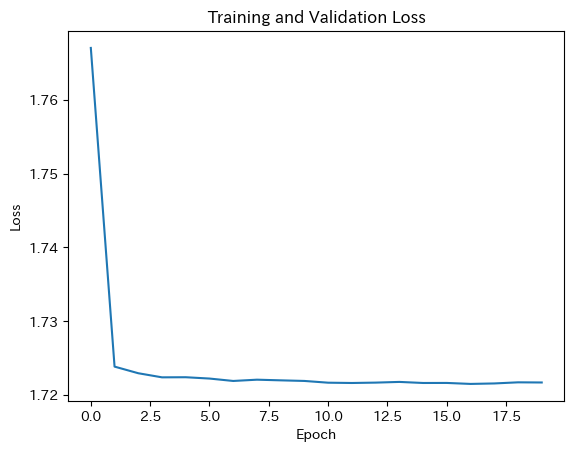

In [11]:
# 損失の可視化
plt.plot(loss_history)
# plt.plot(loss_history_val)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 評価
model.eval()
with torch.no_grad():
    q_test = model(torch.tensor(X_test.values, dtype=torch.float32))
    roi_direct = q_test.numpy()
    roi_direct = roi_direct.reshape(1, -1)[0]

### TPM-SL

In [4]:
# 必要なライブラリのインポート
from sklearn.ensemble import RandomForestRegressor
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor


# モデルの構築
models = LGBMRegressor()
# models = LinearRegression()
S_learner_r = SLearner(overall_model = models)
S_learner_r.fit(y_r_train, T_train, X = X_train)

S_learner_c = SLearner(overall_model = models)
S_learner_c.fit(y_c_train, T_train, X = X_train)

# 効果の推定
tau_r = S_learner_r.effect(X_test)
tau_c = S_learner_c.effect(X_test)
roi_tpmsl = tau_r / tau_c

scaler = MinMaxScaler()
roi_tpmsl = scaler.fit_transform(roi_tpmsl.reshape(-1, 1)).flatten()

# roi_tpmsl = sigmoid(roi_tpmsl)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.002913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.046992


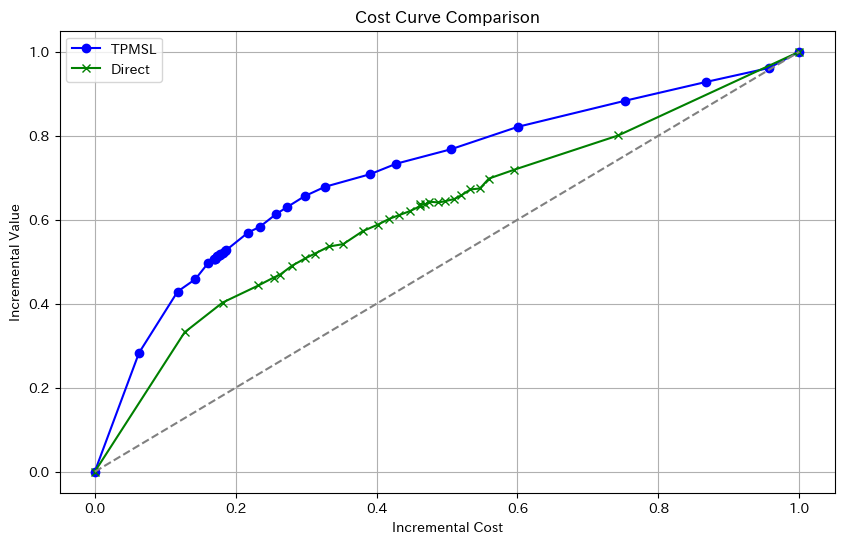

In [12]:
# 処理を関数化して同じ処理を二回行う
def calculate_values(roi_scores):
    sorted_indices = np.argsort(roi_scores)[::-1]
    p_values = np.linspace(0, 1, 30)
    incremental_costs = []
    incremental_values = []
    
    for p in p_values:
        top_p_indices = sorted_indices[:int(p * len(roi_scores))]
        treatment_indices = (T_test[top_p_indices] == 1)
        
        # ATE (Average Treatment Effect) の計算
        ATE_Yr = np.mean(y_r_test[top_p_indices][treatment_indices]) - np.mean(y_r_test[top_p_indices][~treatment_indices])
        ATE_Yc = np.mean(y_c_test[top_p_indices][treatment_indices]) - np.mean(y_c_test[top_p_indices][~treatment_indices])
        
        incremental_costs.append(ATE_Yc * np.sum(treatment_indices))
        incremental_values.append(ATE_Yr * np.sum(treatment_indices))
        # print(ATE_Yr , ATE_Yc,np.sum(treatment_indices))
        
    return incremental_costs, incremental_values

# それぞれのデータセットについて計算
incremental_costs_tpmsl, incremental_values_tpmsl = calculate_values(roi_tpmsl)
incremental_costs_direct, incremental_values_direct = calculate_values(roi_direct)

incremental_costs_direct[0] = 0
incremental_values_direct[0] = 0
incremental_costs_tpmsl[0] = 0
incremental_values_tpmsl[0] = 0

# 横軸と縦軸を正規化してグラフ描画
plt.figure(figsize=(10, 6))
# plt.plot(incremental_costs_tpmsl, incremental_values_tpmsl, marker='o', color='blue', label='TPMSL Model')
# plt.plot(incremental_costs_direct, incremental_values_direct, marker='x', color='green', label='Direct Model')
plt.plot(incremental_costs_tpmsl / max(incremental_costs_tpmsl), incremental_values_tpmsl / max(incremental_values_tpmsl), marker='o', color='blue',  label='TPMSL')
plt.plot(incremental_costs_direct / max(incremental_costs_direct), incremental_values_direct / max(incremental_values_direct), marker='x', color='green', label='Direct')
# y = x の直線
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Cost Curve Comparison')
plt.xlabel('Incremental Cost')
plt.ylabel('Incremental Value')
plt.legend()
plt.grid(True)
plt.show()

## Cost Unaware Treament Assignment Problem

### 訓練データとテストデータに分割

In [20]:
# 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split

X = df.drop(['treatment','exposure','visit','conversion'], axis=1)
X = (X - X.mean()) / X.std()
T = df['treatment']
y = df['visit']

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.3, random_state=42, stratify=T)

### S Learner

In [24]:
# 必要なライブラリのインポート
# from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression

# モデルの構築
# models = RandomForestRegressor(max_depth=10, random_state=0)
models = LGBMRegressor()
S_learner = SLearner(overall_model = models)
S_learner.fit(y_train, T_train, X = X_train)

# 効果の推定
tau_sl = S_learner.effect(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.046992


### X Learner

In [25]:
# 必要なライブラリのインポート
# from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from econml.metalearners import XLearner

# モデルの構築
# models = RandomForestRegressor(max_depth=10, random_state=0)
models = LGBMRegressor()
propensity_model = LogisticRegression()
X_learner = XLearner(models=models, propensity_model=propensity_model)
X_learner.fit(y_train, T_train, X = X_train)

# 効果の推定
tau_xl = X_learner.effect(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 1467856, number of used features: 12
[LightGBM] [Info] Start training from score 0.038205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 8317858, number of used features: 12
[LightGBM] [Info] Start training from score 0.048543
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

### Causal Forest

In [16]:
# # causal forest での効果の推定
# from econml.dml import CausalForestDML
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from statsmodels.nonparametric.kernel_regression import KernelReg

# # モデルの構築
# cf = CausalForestDML(model_y=LinearRegression(),
#                      model_t=LogisticRegression(),
#                      discrete_treatment=True,
#                      n_estimators=4)
# cf.fit(y_train, T_train, X=X_train)

# # 効果の推定
# tau_cf = cf.effect(X_test)

### 提案手法

In [26]:
import numpy as np
from scipy.optimize import minimize

N1 = np.sum(T_train == 1)
N0 = np.sum(T_train == 0)

y_train_1 = y_train[T_train == 1]
y_train_0 = y_train[T_train == 0]

X_train_1 = X_train[T_train == 1]
X_train_0 = X_train[T_train == 0]

def softmax(scores): 
    if scores.ndim == 2:
        scores = scores.T
        scores = scores - np.max(scores, axis=0)
        y = np.exp(scores) / np.sum(np.exp(scores), axis=0)
        return y.T
  
    scores = scores - np.max(scores) # オーバーフロー対策 
    return np.exp(scores) / np.sum(np.exp(scores))


def softmax_naive(scores):
    exps = np.exp(scores)
    return exps / np.sum(exps)

# 損失関数 L(s)
def loss_function(w):
    scores_1 = np.dot(X_train_1, w)
    scores_0 = np.dot(X_train_0, w)
    probabilities_1 = softmax(scores_1)
    probabilities_0 = softmax(scores_0)
    return -np.sum(y_train_1 * np.log(probabilities_1)) / N1 + np.sum(y_train_0 * np.log(probabilities_0)) / N0

# 初期重み
w_initial = np.random.rand(X_train.shape[1])

# 最適化
result = minimize(loss_function, w_initial, method='BFGS')

if result.success:
    print("Optimized weights:", result.x)
    print("Minimum loss:", result.fun)
else:
    print("Optimization failed:", result.message)

# sとqの最適解の導出
w = result.x
scores = np.dot(X_test, w)
probabilities = softmax(scores)
tau_direct = probabilities * np.sum(np.exp(scores))

Optimized weights: [-3.42140466e-01  2.12489789e-02 -6.16203911e-02  4.87857383e-04
 -9.89087155e-02  6.80492704e-02 -5.20510847e-01  3.90852769e-02
 -5.63014680e-01  5.28283866e-02  2.79188789e-02 -3.17643205e-02]
Minimum loss: 0.21767221051414487


In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler
from tqdm import tqdm

# データをテンソルに変換
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
T_train_tensor = torch.tensor(T_train.values, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
# T_val_tensor = torch.tensor(T_val.values, dtype=torch.float32)

# データをテンソルに変換してDatasetを作成
dataset_1 = TensorDataset(X_train_tensor[T_train_tensor == 1], y_train_tensor[T_train_tensor == 1])
dataset_0 = TensorDataset(X_train_tensor[T_train_tensor == 0], y_train_tensor[T_train_tensor == 0])
# dataset_1_val = TensorDataset(X_val_tensor[T_val_tensor == 1], y_val_tensor[T_val_tensor == 1])
# dataset_0_val = TensorDataset(X_val_tensor[T_val_tensor == 0], y_val_tensor[T_val_tensor == 0])

# DataLoaderの定義
loader_1 = DataLoader(dataset_1, batch_size=340, shuffle=True)
loader_0 = DataLoader(dataset_0, batch_size=0, shuffle=True)
# loader_1_val = DataLoader(dataset_1_val, batch_size=170, shuffle=True)
# loader_0_val = DataLoader(dataset_0_val, batch_size=30, shuffle=True)

# 非線形モデルの定義
class NonLinearModel(nn.Module):
    def __init__(self, input_dim):
        super(NonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 36)
        # self.dropout1 = nn.Dropout(0.1) 
        self.fc2 = nn.Linear(36, 18)
        # self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(18, 6)
        # self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(6, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout1(x)  # Dropoutを適用
        x = torch.relu(self.fc2(x))
        # x = self.dropout2(x) 
        x = torch.relu(self.fc3(x))
        # x = self.dropout3(x)
        # 恒等関数を適用
        x = self.fc4(x)

        return x


# model = LogisticRegressionModel(X_train_tensor.shape[1])
model = NonLinearModel(X_train_tensor.shape[1])

# 損失関数の定義
def custom_loss(y, q, group_size):
    # qが0になるのを防ぐ
    q = torch.clamp(q, 1e-8, 1 - 1e-8)

    # 損失計算
    loss = -torch.sum(y * torch.log(q)) / group_size
    return loss

optimizer = optim.Adam(model.parameters(), lr=0.001)
# 1. LambdaLR
# lambda_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

loss_history, loss_history_val = [], []  # 損失を記録するリストを初期化

for (x_1, y_1), (x_0, y_0) in tqdm(zip(loader_1, loader_0)):
    optimizer.zero_grad()
    
    s_1 = model(x_1)
    s_0 = model(x_0)

    q_1 = torch.softmax(s_1, dim=0)
    q_0 = torch.softmax(s_0, dim=0)

    loss_1 = custom_loss(y_1, q_1, x_1.size(0))
    loss_0 = custom_loss(y_0, q_0, x_0.size(0))
    
    loss = loss_1 - loss_0
    # 1回だけlossをprint
    # if count_batches == 0:
        # print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    loss.backward()
    optimizer.step()

    total_loss += loss.item()  # 総損失に今回のバッチの損失を加算
    count_batches += 1

average_loss = total_loss / count_batches  # このエポックの平均損失
loss_history.append(average_loss)  # 損失履歴に追加
# 学習率のスケジューラを更新
# lambda_scheduler.step()

# 検証データでの損失を計算
# model.eval()
# total_val_loss = 0
# count_val_batches = 0
# with torch.no_grad():
#     for (x_1_val, y_r_1_val, y_c_1_val), (x_0_val, y_r_0_val, y_c_0_val) in zip(loader_1_val, loader_0_val):
#         q_1_val = model(x_1_val)
#         q_0_val = model(x_0_val)
        
#         loss_1_val = custom_loss(y_r_1_val, y_c_1_val, q_1_val, x_1_val.size(0))
#         loss_0_val = custom_loss(y_r_0_val, y_c_0_val, q_0_val, x_0_val.size(0))
        
#         loss_val = loss_1_val - loss_0_val
#         total_val_loss += loss_val.item()
#         count_val_batches += 1

# average_val_loss = total_val_loss / count_val_batches
# loss_history_val.append(average_val_loss)


if epoch % 1 == 0:
    print(f'Epoch {epoch}, Average Loss: {average_loss}')


24465it [00:45, 532.57it/s]


Epoch 0, Average Loss: 86.81520851469712


24465it [00:49, 490.11it/s]


Epoch 1, Average Loss: 86.81521098703882


24465it [00:51, 478.43it/s]


Epoch 2, Average Loss: 86.81541175616195


24465it [00:49, 490.10it/s]


Epoch 3, Average Loss: 86.81530524619683


24465it [00:50, 488.56it/s]


Epoch 4, Average Loss: 86.81525368521898


24465it [00:50, 484.80it/s]


Epoch 5, Average Loss: 86.81535796339517


24465it [00:50, 484.76it/s]


Epoch 6, Average Loss: 86.81525590574232


24465it [00:50, 483.27it/s]


Epoch 7, Average Loss: 86.81535754820673


24465it [00:51, 478.56it/s]


Epoch 8, Average Loss: 86.81525249843726


24465it [00:51, 477.36it/s]


Epoch 9, Average Loss: 86.81515065668162


24465it [00:49, 491.01it/s]


Epoch 10, Average Loss: 86.81545895479609


24465it [00:52, 467.12it/s]


Epoch 11, Average Loss: 86.81535398411941


24465it [00:54, 452.33it/s]


Epoch 12, Average Loss: 86.81530312546528


13301it [00:29, 453.95it/s]


KeyboardInterrupt: 

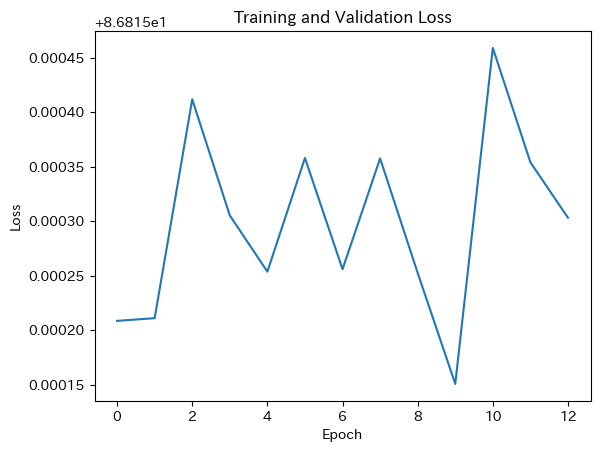

In [83]:
# 損失の可視化
plt.plot(loss_history)
# plt.plot(loss_history_val)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 評価
model.eval()
with torch.no_grad():
    q_test = model(torch.tensor(X_test.values, dtype=torch.float32))
    tau_direct = q_test.numpy() / np.sum(q_test.numpy())

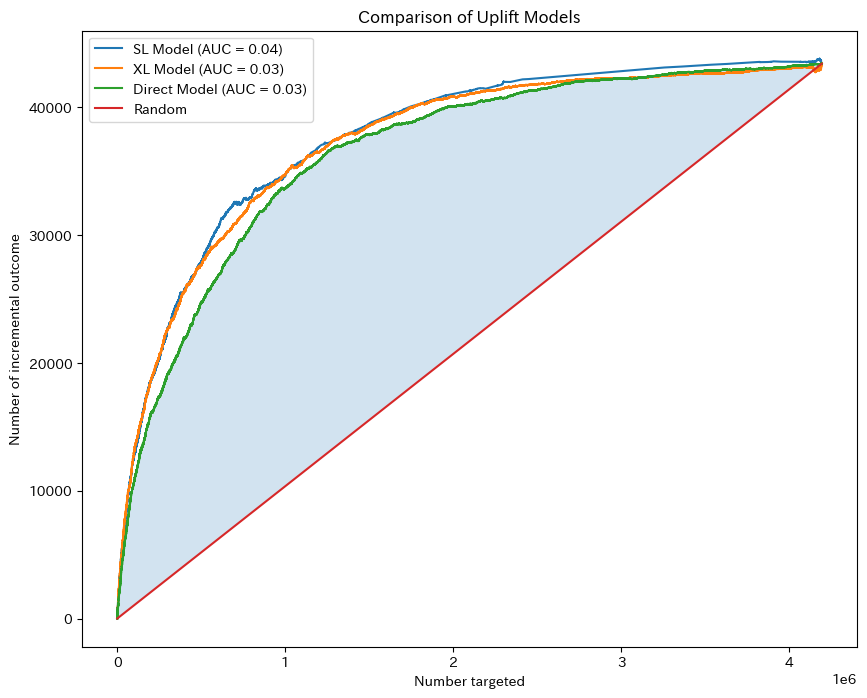

SL Model Uplift AUC: 0.0357
XL Model Uplift AUC: 0.0348
Direct Model Uplift AUC: 0.0330


In [27]:
import matplotlib.pyplot as plt
from sklift.viz import plot_uplift_curve

# データとアップリフトスコアの例（ダミーデータを使用）
# y_test, tau_sl, tau_xl, tau_direct, T_test に相当するデータを用意する

# 描画設定
fig, ax = plt.subplots(figsize=(10, 8))

# SLモデルのアップリフト曲線
plot_uplift_curve(y_true=y_test, uplift=tau_sl, treatment=T_test, perfect=False, random=False, ax=ax, name='SL Model')

# XLモデルのアップリフト曲線
plot_uplift_curve(y_true=y_test, uplift=tau_xl, treatment=T_test, perfect=False, random=False, ax=ax, name='XL Model')

# causal forest でのアップリフト曲線
# plot_uplift_curve(y_true=y_test, uplift=tau_cf, treatment=T_test, perfect=False, random=False, ax=ax, name='Causal Forest')

# Directモデルのアップリフト曲線
plot_uplift_curve(y_true=y_test, uplift=tau_direct, treatment=T_test, perfect=False, ax=ax, name='Direct Model')

ax.set_title('Comparison of Uplift Models')
ax.legend()
plt.show()

# AUCの計算
from sklift.metrics import uplift_auc_score

# SLモデルのAUC
uplift_auc_sl = uplift_auc_score(y_true=y_test, uplift=tau_sl, treatment=T_test)
print(f"SL Model Uplift AUC: {uplift_auc_sl:.4f}")

# XLモデルのAUC
uplift_auc_xl = uplift_auc_score(y_true=y_test, uplift=tau_xl, treatment=T_test)
print(f"XL Model Uplift AUC: {uplift_auc_xl:.4f}")

# causal forest でのAUC
# uplift_auc_cf = uplift_auc_score(y_true=y_test, uplift=tau_cf, treatment=T_test)
# print(f"Causal Forest Uplift AUC: {uplift_auc_cf:.4f}")

# DirectモデルのAUC
uplift_auc_direct = uplift_auc_score(y_true=y_test, uplift=tau_direct, treatment=T_test)
print(f"Direct Model Uplift AUC: {uplift_auc_direct:.4f}")


In [13]:
tau_direct

array([[2.384428e-07],
       [2.384428e-07],
       [2.384428e-07],
       ...,
       [2.384428e-07],
       [2.384428e-07],
       [2.384428e-07]], dtype=float32)

In [14]:
tau_sl

array([0.00033222, 0.0039092 , 0.00015132, ..., 0.00033222, 0.00133341,
       0.00180258])